Original source for majority of the code below is Dr. Ulya Bayram, but some codes are obtained from d2l library and modified for better understanding of the coding principles.



In [6]:
%matplotlib inline
import numpy as np
import torch
import math
import matplotlib.pyplot as plt

In [3]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    plt.figure(figsize=(6, 4))
    plt.plot(f_line, [f(x) for x in f_line], '-', label='f(x)')
    plt.plot(results, [f(x) for x in results], 'x', label='f(x)', linestyle='None')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.show()

In [4]:
#@ save
def train_2d(trainer, steps=20, f_grad=None):  
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    plt.figure(figsize=(6, 4))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1), torch.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

# Momentum

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

As before $f$ has its minimum at $(0, 0)$. This function is *very* flat in the direction of $x_1$.

In [ ]:

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)


Averaging gradients over the past would work well. 

After all, in the $x_1$ direction this will aggregate well-aligned gradients, thus increasing the distance we cover with every step. 

Conversely, in the $x_2$ direction where gradients oscillate, an aggregate gradient will reduce step size due to oscillations that cancel each other out.

Using $\mathbf{v}_t$ instead of the gradient $\mathbf{g}_t$ yields the following update equations:

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

epoch 20, x1: 0.007188, x2: 0.002553


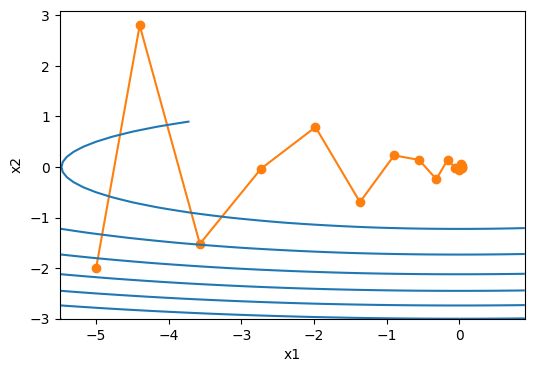

In [ ]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d))

epoch 20, x1: -0.126340, x2: -0.186632


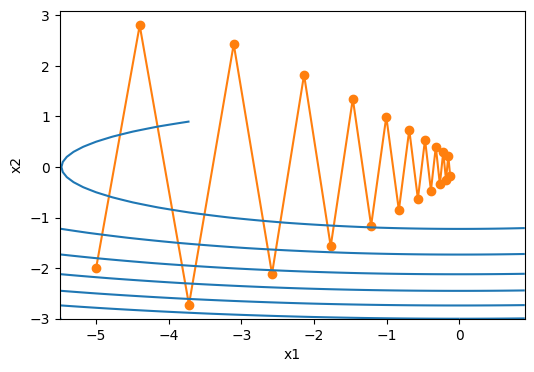

In [ ]:
# Daha az momentum?

eta, beta = 0.6, 0.25
show_trace_2d(f_2d, train_2d(momentum_2d))

# AdaGrad

Learning rate yani $\eta_t$ zamanla kendi kendine gradientlere göre update oluyor, saat gibi.

$$
\begin{aligned}
\mathbf{s}_t &\leftarrow \mathbf{s}_{t-1} + \mathbf{g}_{t}^2 \\

\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \frac{\eta_t * \mathbf{g}_{t}}{\sqrt{\mathbf{s}_t + \epsilon}}
\end{aligned}
$$

In [ ]:
import math

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta * g1 / math.sqrt(s1 + eps)
    x2 -= eta * g2 / math.sqrt(s2 + eps)
    return x1, x2, s1, s2

eta = 0.4
show_trace_2d(f_2d, train_2d(adagrad_2d))

epoch 20, x1: -0.002295, x2: -0.000000


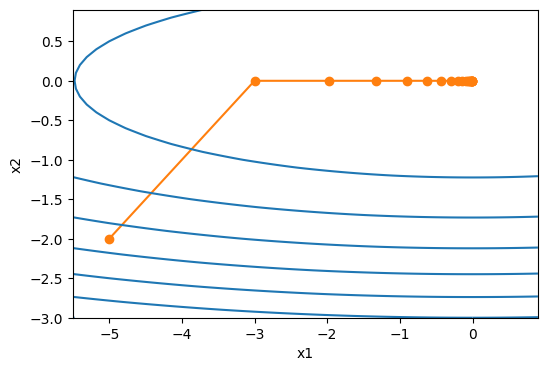

In [ ]:
eta = 2
show_trace_2d(f_2d, train_2d(adagrad_2d))

# RMSProp

Learning rate yani $\eta_t$ yine zamanla kendi kendine gradientlere göre update oluyor, saat gibi. Sadece, $\gamma$'yı istediğimiz gibi seçerek gradientlerin learning rate'i ne kadar etkilemesine biz karar veriyoruz.

$$
\begin{aligned}
\mathbf{s}_t &\leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_{t}^2 \\

\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \frac{\eta_t * \mathbf{g}_{t}}{\sqrt{\mathbf{s}_t + \epsilon}}
\end{aligned}
$$

epoch 20, x1: -0.010599, x2: 0.000000


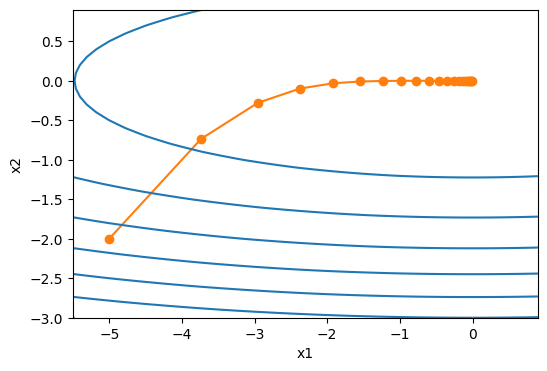

In [ ]:
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

eta, gamma = 0.4, 0.9
show_trace_2d(f_2d, train_2d(rmsprop_2d))

# AdaDelta

Learning rate istemiyoruz. Kendi kendimize onu hesaplamak için yine zamanla kendi kendine gradientlere göre update olan bir formül kullanıyoruz. 

Bir de leaky average ekliyoruz hesaba.

$$
\begin{aligned}
\mathbf{s}_t &\leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_{t}^2 \\

\mathbf{g}_{t}' = \frac{\sqrt{\Delta x_{t-1} + \epsilon}}{\sqrt{\Delta s_{t} + \epsilon}}*\mathbf{g}_{t} \\

\Delta x_{t-1} = \gamma \Delta x_{t-2} + (1 - \gamma)\mathbf{g}_{t}'^2 \\

x_t &\leftarrow x_{t-1} - \mathbf{g}_{t}'
\end{aligned}
$$

epoch 1002, x1: 0.000000, x2: 0.013086
epoch 1003, x1: 0.000000, x2: -0.013093
epoch 1004, x1: 0.000000, x2: 0.013100
epoch 1005, x1: 0.000000, x2: -0.013108
epoch 1006, x1: 0.000000, x2: 0.013115
epoch 1007, x1: 0.000000, x2: -0.013122
epoch 1008, x1: 0.000000, x2: 0.013129
epoch 1009, x1: 0.000000, x2: -0.013136
epoch 1010, x1: 0.000000, x2: 0.013143
epoch 1011, x1: 0.000000, x2: -0.013150
epoch 1012, x1: 0.000000, x2: 0.013158
epoch 1013, x1: 0.000000, x2: -0.013165
epoch 1014, x1: 0.000000, x2: 0.013172
epoch 1015, x1: 0.000000, x2: -0.013179
epoch 1016, x1: 0.000000, x2: 0.013186
epoch 1017, x1: 0.000000, x2: -0.013193
epoch 1018, x1: 0.000000, x2: 0.013200
epoch 1019, x1: 0.000000, x2: -0.013207
epoch 1020, x1: 0.000000, x2: 0.013214
epoch 1021, x1: 0.000000, x2: -0.013221
epoch 1022, x1: 0.000000, x2: 0.013229
epoch 1023, x1: 0.000000, x2: -0.013236
epoch 1024, x1: 0.000000, x2: 0.013243
epoch 1025, x1: 0.000000, x2: -0.013250
epoch 1026, x1: 0.000000, x2: 0.013257
epoch 1027, x

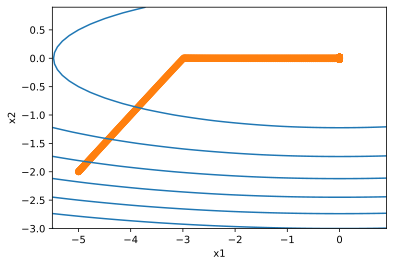

In [ ]:
# Author: Dr. Ulya Bayram

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def train_2d_for_delta(trainer, steps=20, f_grad=None):  
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` `s2` `delta_x1` `delta_x2` `g_prime_1` `g_prime_2`  are internal state variables used in adadelta
    x1, x2, s1, s2, delta_x1, delta_x2, g_prime_1, g_prime_2 = -5, -2, 0, 0, 0, 0, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2, delta_x1, delta_x2, g_prime_1, g_prime_2 = trainer(x1, x2, s1, s2, delta_x1, delta_x2, g_prime_1, g_prime_2, f_grad)
        else:
            x1, x2, s1, s2, delta_x1, delta_x2, g_prime_1, g_prime_2 = trainer(x1, x2, s1, s2, delta_x1, delta_x2, g_prime_1, g_prime_2)
        results.append((x1, x2))
        print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def adadelta_2d(x1, x2, s1, s2, delta_x1, delta_x2, g_prime_1, g_prime_2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2

    delta_x1 = gamma * delta_x1 + (1-gamma) * g_prime_1 ** 2
    delta_x2 = gamma * delta_x2 + (1-gamma) * g_prime_2 ** 2

    g_prime_1 = math.sqrt(delta_x1 + eps) * g1 / math.sqrt(s1 + eps)
    g_prime_2 = math.sqrt(delta_x2 + eps) * g2 / math.sqrt(s2 + eps)

    x1 -= g_prime_1
    x2 -= g_prime_2

    return x1, x2, s1, s2, delta_x1, delta_x2, g_prime_1, g_prime_2

gamma = 0.01
num_steps = 2000
show_trace_2d(f_2d, train_2d_for_delta(adadelta_2d, steps = num_steps))


# Adam

exponential moving averages with two state variables:

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_{t} \\
\mathbf{s}_t &\leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_{t}^2 \\
\end{aligned}
$$

Normalize these state variables:

$$
\begin{aligned}
\mathbf{\hat{v}}_{t} = \frac{\mathbf{v}_t}{1 - \beta_1 ^ \alpha} \\
\mathbf{\hat{s}}_{t} = \frac{\mathbf{s}_t}{1 - \beta_2 ^ \alpha} \\
\end{aligned}
$$

$$
\begin{aligned}
\mathbf{g}_{t}' = \frac{\eta \mathbf{\hat{v}}_{t}}{\sqrt{\mathbf{\hat{s}}_{t}} + \epsilon}\\

x_t &\leftarrow x_{t-1} - \mathbf{g}_{t}'
\end{aligned}
$$

epoch 1, x1: -4.900000, x2: -1.900000
epoch 2, x1: -4.765694, x2: -1.765840
epoch 3, x1: -4.609445, x2: -1.610176
epoch 4, x1: -4.438055, x2: -1.440258
epoch 5, x1: -4.256039, x2: -1.261212
epoch 6, x1: -4.066683, x2: -1.077101
epoch 7, x1: -3.872506, x2: -0.891392
epoch 8, x1: -3.675510, x2: -0.707204
epoch 9, x1: -3.477326, x2: -0.527428
epoch 10, x1: -3.279306, x2: -0.354787
epoch 11, x1: -3.082588, x2: -0.191836
epoch 12, x1: -2.888135, x2: -0.040924
epoch 13, x1: -2.696772, x2: 0.095881
epoch 14, x1: -2.509206, x2: 0.216878
epoch 15, x1: -2.326045, x2: 0.320815
epoch 16, x1: -2.147812, x2: 0.406952
epoch 17, x1: -1.974955, x2: 0.475079
epoch 18, x1: -1.807855, x2: 0.525497
epoch 19, x1: -1.646834, x2: 0.558955
epoch 20, x1: -1.492159, x2: 0.576569
epoch 21, x1: -1.344046, x2: 0.579724
epoch 22, x1: -1.202665, x2: 0.569990
epoch 23, x1: -1.068142, x2: 0.549035
epoch 24, x1: -0.940562, x2: 0.518567
epoch 25, x1: -0.819971, x2: 0.480282
epoch 26, x1: -0.706378, x2: 0.435831
epoch 27,

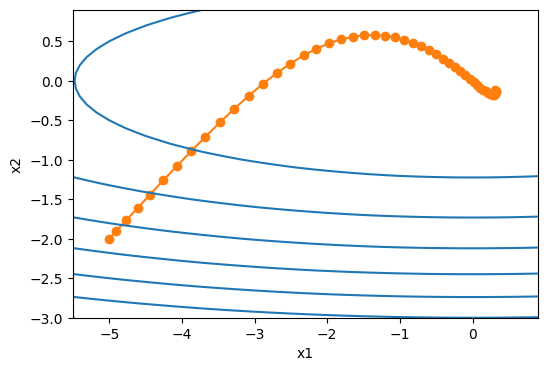

In [18]:
# Author: Dr. Ulya Bayram

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def train_2d_for_adam(trainer, steps=20, f_grad=None):  
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` `s2` `v1` `v2` `g_prime_1` `g_prime_2`  are internal state variables used in adadelta
    x1, x2, s1, s2, v1, v2, g_prime_1, g_prime_2 = -5, -2, 0, 0, 0, 0, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2, v1, v2, g_prime_1, g_prime_2 = trainer(x1, x2, s1, s2, v1, v2, g_prime_1, g_prime_2, f_grad)
        else:
            x1, x2, s1, s2, v1, v2, g_prime_1, g_prime_2 = trainer(x1, x2, s1, s2, v1, v2, g_prime_1, g_prime_2)
        results.append((x1, x2))
        print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def adam_2d(x1, x2, s1, s2, v1, v2, g_prime_1, g_prime_2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6

    v1 = beta_1 * v1 + (1 - beta_1) * g1
    v2 = beta_1 * v2 + (1 - beta_1) * g2

    s1 = beta_2 * s1 + (1 - beta_2) * g1 ** 2
    s2 = beta_2 * s2 + (1 - beta_2) * g2 ** 2

    # normalize v_t and s_t
    v_1_norm = v1 / (1 - beta_1 ** alpha)
    v_2_norm = v2 / (1 - beta_1 ** alpha)

    s_1_norm = s1 / (1 - beta_2 ** alpha)
    s_2_norm = s2 / (1 - beta_2 ** alpha)

    g_prime_1 = eta * v_1_norm / (eps + math.sqrt(s_1_norm))
    g_prime_2 = eta * v_2_norm / (eps + math.sqrt(s_2_norm))

    x1 -= g_prime_1
    x2 -= g_prime_2

    return x1, x2, s1, s2, v1, v2, g_prime_1, g_prime_2

beta_1, beta_2, alpha, eta = 0.9, 0.999, 1, 0.1
num_steps = 50
show_trace_2d(f_2d, train_2d_for_adam(adam_2d, steps = num_steps))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=700e962d-3fcf-4c82-8c8d-f1f2cc26fdf7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>